In [55]:
#OD数据预处理

#读取xlsx数据
import pandas as pd
import numpy as np
data = pd.read_excel('../data/OD_Demand_of_Changzhi_City _2024_A.xlsx',sheet_name='Sheet1')


data.head()

# 将每个小区名称和对应的小区编号存储在字典中
area_dict = {}
for i in range(len(data)):
    if data['小区名称'][i] in area_dict:
        area_dict[data['小区名称'][i]].append(data['小区编号'][i])
    else:
        area_dict[data['小区名称'][i]] = [data['小区编号'][i]]

# area_dict一共有多少个小区
#len(area_dict)  # 25个

#新建一个dataframe，每一列为area_dict中的小区编号列表列的加和
data_grouped = pd.DataFrame()
data_grouped['小区编号'] = data['小区编号']
data_grouped['小区名称'] = data['小区名称']
for key in area_dict:
    data_grouped[key] = data[area_dict[key]].sum(axis=1)

# 将小区名称相同的行加和
data_by_area = data_grouped.groupby('小区名称').sum()

# 删除小区编号列
data_by_area.drop('小区编号', axis=1, inplace=True)

# 将小区名称按照列名排序
data_by_area = data_by_area[sorted(data_by_area.columns)]

data_by_area.head()

,东八一广场商务区,五一路现代居住区,产业配套居住区,城东现在居住区,城北生态居住区,城北科技园,城北科技园服务区,城区机械工业园区,城南教育科研区,城南生态居住区,...,火车站物流商贸区,火车站配套居住区,生态区居住区,老顶山开发区,西八一广场商务区,解放东路居住区,解放西路居住区,长兴路居住区,马厂,高等教育园区
小区名称,,,,,,,,,,,,,,,,,,,,,
东八一广场商务区,956.681831,83.770902,54.493179,159.888088,55.980363,52.881764,62.335565,40.511703,194.072645,49.799086,...,75.065678,47.671125,125.753470,193.016630,296.693784,58.735558,125.651382,46.545638,12.106557,228.862057
五一路现代居住区,241.678155,390.595258,25.787033,62.429800,28.941848,55.606416,85.718661,33.864248,105.832003,34.408622,...,171.368320,144.034812,77.339356,92.465032,340.155965,34.952067,142.305690,23.768275,12.896500,95.325492
产业配套居住区,340.008355,59.179513,674.361107,114.862393,25.066971,40.185509,42.564211,193.542075,332.140981,151.295230,...,91.732531,79.627378,468.679146,113.223859,245.902199,77.054066,205.228302,38.185551,8.163962,117.448385
城东现在居住区,260.820573,41.839796,32.825009,375.978053,25.785372,29.082262,29.788830,39.340786,129.093018,23.529650,...,48.472782,36.521329,67.457053,197.677241,134.846634,92.556134,80.398024,27.355082,6.585613,128.701717
城北生态居住区,143.908644,34.446150,11.280230,39.233215,188.067326,66.051663,58.570005,17.359688,40.201692,15.176390,...,39.908316,26.897229,38.315913,73.108992,140.556016,14.823354,48.987227,42.692684,18.542498,110.327331


得到了25*25的大区OD对

data_by_area


In [6]:
# 将data_by_area保存为csv文件, 中文编码

data_by_area.to_csv('./OD_By_Area.csv', encoding='utf_8_sig')

0
LINKS
ZONES
LEGEND
MARKINGS
Defpoints


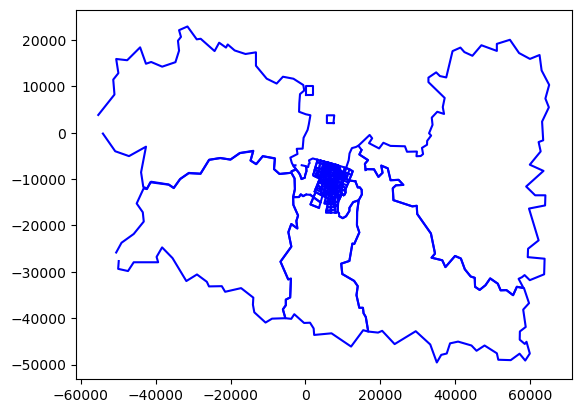

In [60]:
import ezdxf
import matplotlib.pyplot as plt
import dxfgrabber
import geopandas as gpd
from shapely.geometry import LineString

# 打开 DXF 文件
dxf = ezdxf.readfile('../data/road_network_and_traffic_zones_of_changzhi_city_2024.dxf')

# 列举 DXF 文件中的图层
for layer in dxf.layers:
    print(layer.dxf.name)

# 绘制ZONES图层，zones表示OD小区
links = [e for e in dxf.modelspace() if e.dxftype() == 'LWPOLYLINE' and e.dxf.layer == 'ZONES']
for link in links:
    points = link.get_points('xy')
    plt.plot([p[0] for p in points], [p[1] for p in points], 'b')

plt.show()

#每个zone有一个编号，将zone编号和zone的坐标存储在字典中
zone_dict = {}
for link in links:
    zone_dict[link.dxf.handle] = link.get_points('xy')
    
#print(len(zone_dict)) #198

#直接打印ZONES图层
#print(len(links)) #links的长度为198 说明并非与小区一一对应


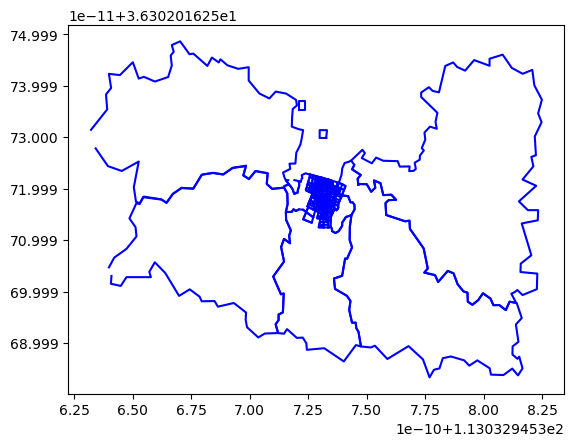

In [59]:
# 对坐标进行一定的处理，使其和地图经纬度对应
# 点(5491.2, -17209.2)对应经纬度(113.095857, 36.135466)
# 点(3228.6, -16628.0)对应经纬度(113.06939, 36.141079)

# 将坐标转换为经纬度
def convert_xy_to_latlon(xy):
    x, y = xy
    lon = 113.06939 + (x - 3228.6) / (5491.2 - 3228.6) * (113.095857 - 113.06939)
    lat = 36.141079 + (y - (-16628.0)) / (-17209.2 - (-16628.0)) * (36.135466 - 36.141079)
    return (lon, lat)


# 将links中的坐标转换为经纬度
for link in links:
    points = link.get_points('xy')
    points = [convert_xy_to_latlon(p) for p in points]
    link.set_points(points)

# 打印一下links
for link in links:
    points = link.get_points('xy')
    plt.plot([p[0] for p in points], [p[1] for p in points], 'b')

# 使用folium绘制地图，注意经纬度匹配
import folium

m = folium.Map(location=[36.141079, 113.06939], zoom_start=13)

for link in links:
    points = link.get_points('xy')
    folium.PolyLine(points, color='blue').add_to(m)

m.save('./OD_Zones.html')

0
LINKS
ZONES
LEGEND
MARKINGS
Defpoints
['79', '7D', '81', '85', '89', '8D', '92', '96', '9A', '9F', 'A4', 'A8', 'AC', 'B0', 'B4', 'B8', 'BC', 'C0', 'C4', 'C8', 'CC', 'D1', 'D6', 'DB', 'E0', 'E4', 'E8', 'EC', 'F0', 'F4', 'F8', 'FC', '100', '105', '109', '10D', '111', '115', '119', '11D', '121', '125', '129', '12D', '131', '135', '139', '13D', '141', '145', '149', '14D', '151', '155', '159', '15D', '161', '165', '169', '16D', '171', '175', '179', '17D', '181', '185', '189', '18F', '193', '197', '19B', '19F', '1A3', '1A7', '1AB', '1AF', '1B3', '1B7', '1BC', '1C0', '1C4', '1C8', '1CC', '1D0', '1D5', '1D9', '1DD', '1E1', '1E5', '1E9', '1ED', '1F1', '1F5', '1F9', '1FD', '201', '205', '209', '20E', '212', '216', '21A', '21E', '222', '226', '22B', '22F', '233', '237', '23B', '23F', '243', '247', '24B', '24F', '253', '257', '25B', '25F', '263', '267', '26B', '26F', '273', '277', '27B', '27F', '283', '287', '28C', '290', '294', '298', '29C', '2A0', '2A4', '2A8', '2AC', '2B0', '2B4', '2B8', '2BC

,geometry
0,"LINESTRING (3591.900 -8296.100, 3456.800 -8672..."
1,"LINESTRING (6482.500 -9164.800, 6554.800 -8926..."
2,"LINESTRING (6482.500 -9164.800, 6443.000 -9287..."
3,"LINESTRING (6482.500 -9164.800, 6380.600 -9139..."
4,"LINESTRING (6482.500 -9164.800, 6720.700 -9240..."


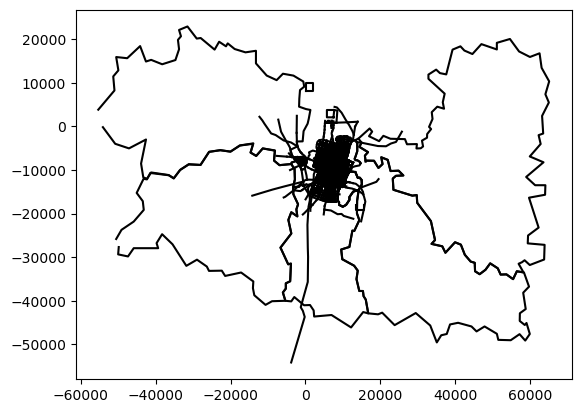

In [10]:

#读取CAD的dxf文件

import ezdxf
import matplotlib.pyplot as plt
import dxfgrabber
import geopandas as gpd
from shapely.geometry import LineString

# 打开 DXF 文件
dxf = ezdxf.readfile('../data/road_network_and_traffic_zones_of_changzhi_city_2024.dxf')

modelspace = dxf.modelspace()

# 创建一个 matplotlib 图形
fig, ax = plt.subplots()

# 列举 DXF 文件中的图层
for layer in dxf.layers:
    print(layer.dxf.name)

# 遍历 DXF 文件中的图形对象
for entity in modelspace:
    if entity.dxftype() == 'LINE':
        x = [entity.dxf.start.x, entity.dxf.end.x]
        y = [entity.dxf.start.y, entity.dxf.end.y]
        ax.plot(x, y, color='black')
    elif entity.dxftype() == 'LWPOLYLINE':
        x = [point[0] for point in entity.get_points('xy')]
        y = [point[1] for point in entity.get_points('xy')]
        ax.plot(x, y, color='black')
        
# 储存DXF中的编号
dxf_ids = []
for entity in modelspace:
    dxf_ids.append(entity.dxf.handle)

print(dxf_ids)

# Read the DXF file
dxf = dxfgrabber.readfile('../data/road_network_and_traffic_zones_of_changzhi_city_2024.dxf')

lines = []
# Iterate over all entities in the modelspace
for entity in dxf.entities:
    if entity.dxftype == 'LINE':
        # Create a LineString for each line
        line = LineString([entity.start, entity.end])
        lines.append(line)
    elif entity.dxftype == 'LWPOLYLINE':
        # Create a LineString for each polyline
        line = LineString(entity.points)
        lines.append(line)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=lines)

gdf.head()
# Now you can use gdf with GeoPandas


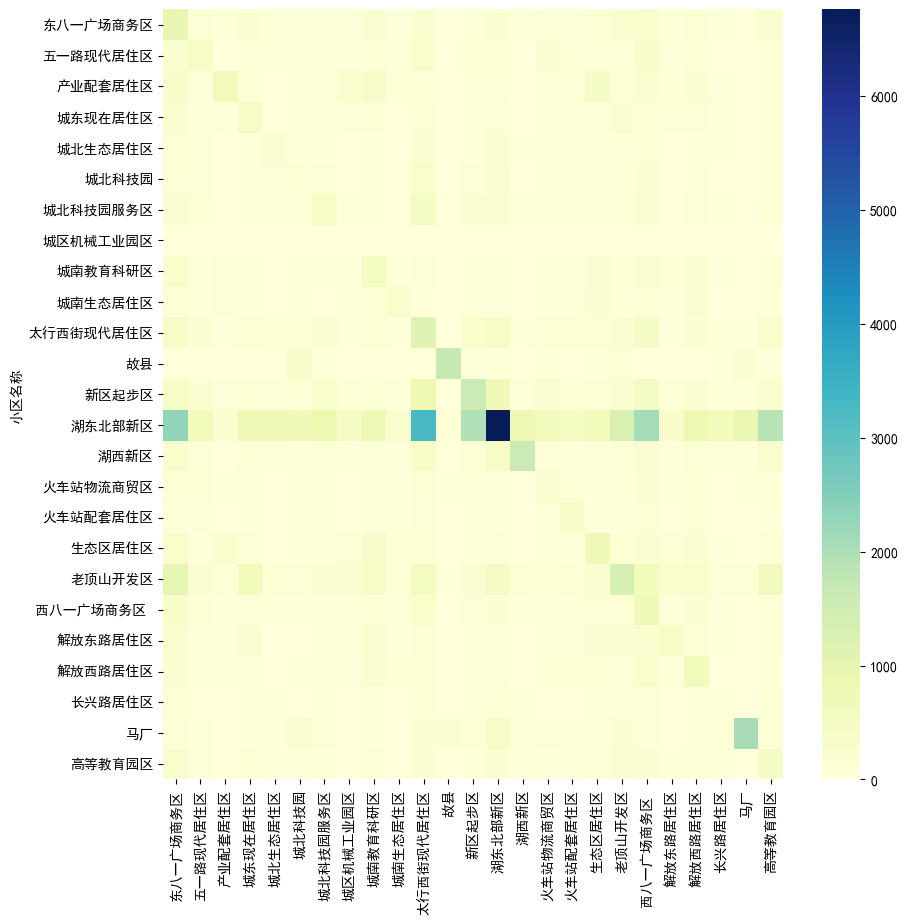

In [36]:
#可视化OD数据，中文编码
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']

plt.figure(figsize=(10, 10))
sns.heatmap(data_by_area, cmap='YlGnBu')
plt.show()